**1. Import dataset TESS (Toronto
Emotional Speech Set)**

In [34]:
#from google.colab import drive
#drive.mount('/content/drive')
#%cd /content/drive/MyDrive/kerja_praktik/data/dataverse_files
%cd /home/fafa/Documents/speech_emotion_recognition/data/dataverse_files/

/home/fafa/Documents/speech_emotion_recognition/data/dataverse_files


In [38]:
# %reset -sf
pwd

'/home/fafa/Documents/speech_emotion_recognition/data/dataverse_files'

**2. Import library**

In [39]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob
import re
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Dropout, Activation


**3. Pembuatan dataframe**

Membuat kerangka data dari file dalam dataset

In [40]:
import_data = 1 # 1 for import saved data, 0 for extract emotion

if import_data == 1:
  df = pd.read_pickle("data_emotion.pkl")
else:
  df = pd.DataFrame(columns=["Path", "Age", "Emotion", "Class"])
  files = glob.glob("*.wav")
  files.sort()
  for file in files:
    print("processing ...", file)
    age = os.path.basename(file).split('_')[0]
    emotion = os.path.basename(file).split('_')[2]
    emotion = emotion[0:-4]
    if age == "OAF":
      age = "Old"
      category = "Old and "+emotion
    else:
      age = "Young"
      category = "Young and "+emotion
    df = df.append({"Path":file,"Age":age,"Emotion":emotion,"Class":category},ignore_index=True)
  df.to_pickle("data_emotion.pkl")

**4. Penampilan Dataframe**

In [41]:
df

,Path,Age,Emotion,Class
0,OAF_back_angry.wav,Old,angry,Old and angry
1,OAF_back_disgust.wav,Old,disgust,Old and disgust
2,OAF_back_fear.wav,Old,fear,Old and fear
3,OAF_back_happy.wav,Old,happy,Old and happy
4,OAF_back_neutral.wav,Old,neutral,Old and neutral
...,...,...,...,...
2795,YAF_youth_fear.wav,Young,fear,Young and fear
2796,YAF_youth_happy.wav,Young,happy,Young and happy
2797,YAF_youth_neutral.wav,Young,neutral,Young and neutral
2798,YAF_youth_ps.wav,Young,ps,Young and ps


**5. Visualisasi Audio**

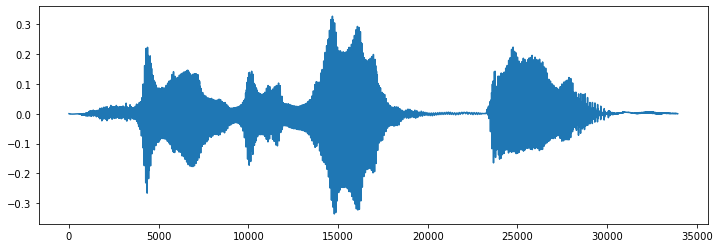

In [42]:
audio_file_path = df.iloc[0]["Path"]
librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)

plt.figure(figsize =(12, 4))
plt. plot(librosa_audio_data)

**6.  Ekstraksi fitur Menggunakan MFCC**

In [45]:
def features_extractor(file):
  print("processing ...", file)
  audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
  mfccs_features =  librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
  mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
  return mfccs_scaled_features

**7. Menampilkan Hasil Ekstraksi Fitur**

In [46]:
df["Features"] = df["Path"].apply(lambda x: features_extractor(x))
df

processing ... OAF_back_angry.wav
processing ... OAF_back_disgust.wav
processing ... OAF_back_fear.wav
processing ... OAF_back_happy.wav
processing ... OAF_back_neutral.wav
processing ... OAF_back_ps.wav
processing ... OAF_back_sad.wav
processing ... OAF_bar_angry.wav
processing ... OAF_bar_disgust.wav
processing ... OAF_bar_fear.wav
processing ... OAF_bar_happy.wav
processing ... OAF_bar_neutral.wav
processing ... OAF_bar_ps.wav
processing ... OAF_bar_sad.wav
processing ... OAF_base_angry.wav
processing ... OAF_base_disgust.wav
processing ... OAF_base_fear.wav
processing ... OAF_base_happy.wav
processing ... OAF_base_neutral.wav
processing ... OAF_base_ps.wav
processing ... OAF_base_sad.wav
processing ... OAF_bath_angry.wav
processing ... OAF_bath_disgust.wav
processing ... OAF_bath_fear.wav
processing ... OAF_bath_happy.wav
processing ... OAF_bath_neutral.wav
processing ... OAF_bath_ps.wav
processing ... OAF_bath_sad.wav
processing ... OAF_bean_angry.wav
processing ... OAF_bean_disgu

,Path,Age,Emotion,Class,Features
0,OAF_back_angry.wav,Old,angry,Old and angry,"[-387.26328, 58.09705, -23.014156, -6.4362698,..."
1,OAF_back_disgust.wav,Old,disgust,Old and disgust,"[-487.85187, 97.89603, 2.2619622, 3.044031, 5...."
2,OAF_back_fear.wav,Old,fear,Old and fear,"[-439.19598, 68.50909, -4.808176, -1.6327962, ..."
3,OAF_back_happy.wav,Old,happy,Old and happy,"[-471.6008, 91.209015, 3.2708457, -4.7777486, ..."
4,OAF_back_neutral.wav,Old,neutral,Old and neutral,"[-532.4035, 93.87202, 6.0608053, 9.067056, 7.7..."
...,...,...,...,...,...
2795,YAF_youth_fear.wav,Young,fear,Young and fear,"[-343.40387, 32.59755, -9.197987, 25.315773, 0..."
2796,YAF_youth_happy.wav,Young,happy,Young and happy,"[-345.47714, 24.427338, -14.398651, 36.95299, ..."
2797,YAF_youth_neutral.wav,Young,neutral,Young and neutral,"[-416.72632, 71.14924, -1.1160219, 42.52479, -..."
2798,YAF_youth_ps.wav,Young,ps,Young and ps,"[-374.82407, 46.681873, -12.381615, 18.139082,..."


**8. Label Encoding**

Label encoding digunakan untuk mengubah label yang berbentuk kategorikal menjadi numerik. Dimana angka 1 untuk yang berumur muda dan angka 0 untuk yang berumur tua.

In [ ]:
X = np.array(df["Features"].to_list())
y = df["Class"].values
encoder = LabelEncoder()
y = to_categorical(encoder.fit_transform(y))
y

**9. Normalisasi Array**

Membagi Dataset menjadi Data Testing dan Training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

**10. Membuat model dan summary model**

In [ ]:
# Creating a sequential model
model = Sequential()

# Adding a dense layer of 100 neurons
model.add(Dense(100))

# Applying rectified linear unit activation function
model.add(Activation('relu'))

# Applying dropout with probability of 0.2
model.add(Dropout(0.2))
model.add(Flatten())

# Adding a dense layer of 7 neurons
model.add(Dense(7))

# Applying 'softmax' activation
model.add(Activation('softmax'))

**11. Compile model**

Kompilasi model dengan '*categorical_crossentropy*' sebagai loss dan 'rmsprop' sebagai pengoptimal.

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='rmsprop')

**12. Train model**

Menggunakan 100 epoch dalam melatih model.

In [ ]:
num_epochs = 100
num_batch_size = 64
# Fitting the model
history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test))

**13. Menghitung akurasi model**

In [ ]:
scores = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

**14. Menampilkan plot**

In [ ]:
# Visualizing the loss and accuracy
plt.figure(figsize=(12,6), dpi=80)

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.plot()

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.plot()

**15. Confusion matriks**

In [ ]:
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer

model_ANN = confusion_matrix(np.argmax(y_test, axis=1), model_predicted)
np.set_printoptions(precision=2)
print(model_ANN)
plt.figure()
ax = plt.subplot()
sns.heatmap(model_ANN, annot=True, ax=ax)

ax.set_xlabel('Predict labels')
ax.set_title('Confusion matrix')

**16. ROC (Receiver Operating Characteristics)**

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test.ravel(), model_pred.ravel())
auc_ = auc(fpr,tpr)

plt.figure(1)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='ROC (area - {:.3f})'.format(auc_))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legen(loc='best')
plt.show()

**17. Classification repot**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))